# Notebook to analyze GEFS T2M output 

## Import modules

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

## Read in the daily averaged (in UTC) GEFS forecast data. See separate script (download_gefs.py) for downloading and processing GEFS 16-day and 31 ensemble member data.

In [2]:
# Here we will use the GEFS 21 June 2025 00Z forecast.
ds = xr.open_dataset('GEFS_20250621_00z_t2m.nc')

In [3]:
# View the xarray dataset first. The data contains daily averaged T2M data from GEFS with shape
# (forecast day, ensemble member, latitude, longitude).
ds

<xarray.Dataset>
Dimensions:     (latitude: 361, longitude: 720, number: 31, valid_time: 16)
Coordinates:
  * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
  * latitude    (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude   (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * valid_time  (valid_time) datetime64[ns] 2025-06-21 2025-06-22 ... 2025-07-06
Data variables:
    t2m         (valid_time, number, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-06-21T23:28 GRIB to CDM+CF via cfgrib-0.9.1...

## Get the ensemble mean global data for a given day.

In [4]:
# Choose a date. Here we can choose a date in the forecast!
chosen_date = '2025-06-23'
# Now select the T2M data for this date, take the ensemble mean, and convert to degrees C.
t2m_on_date = ds.sel(valid_time=chosen_date).mean(dim = 'number', skipna = True) - 273.15 # Ensure skipping NaN values.

In [5]:
# Check if the ensemble mean for the selected day looks ok.
t2m_on_date

<xarray.Dataset>
Dimensions:     (latitude: 361, longitude: 720)
Coordinates:
  * latitude    (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude   (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
    valid_time  datetime64[ns] 2025-06-23
Data variables:
    t2m         (latitude, longitude) float32 0.119 0.119 ... -43.41 -43.41

## Now plot the global ensemble mean data

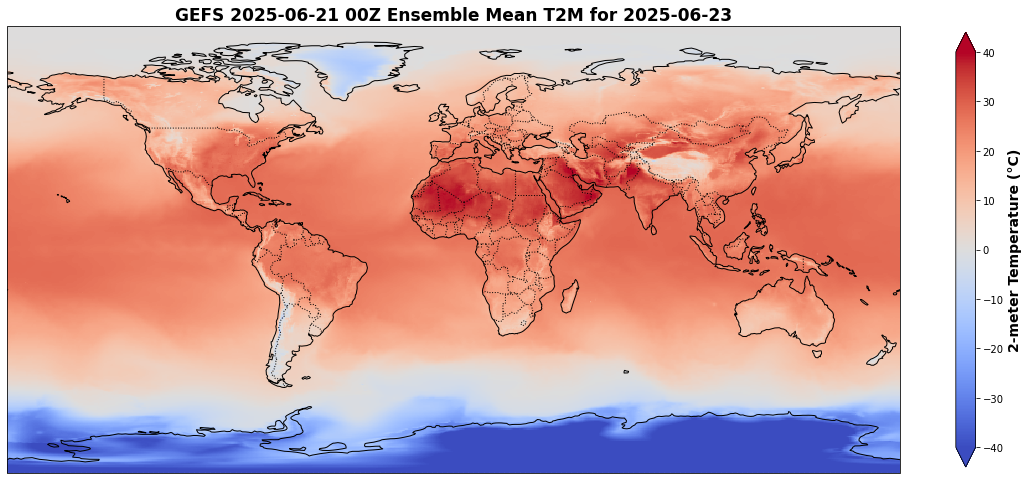

In [6]:
# Now plot the data.
# Generate a figure.
fig = plt.figure(figsize=(20, 10))
# Add axes.
ax = plt.axes(projection=ccrs.PlateCarree())
# Plot the data with colorbar information.
plot = t2m_on_date['t2m'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-40, vmax=40, cbar_kwargs={
        'orientation': 'vertical',
        'shrink': 0.8,
        'extend': 'both',
        'ticks': list(range(-40, 50, 10))
    })
# Add coastlines and borders.
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
# Set the title.
ax.set_title(f'GEFS 2025-06-21 00Z Ensemble Mean T2M for {chosen_date}', fontsize = 17, weight = 'bold')
# Set colorbar details.
colorbar = plot.colorbar
colorbar.set_label('2-meter Temperature (°C)', fontsize=14, weight='bold')
# Show figure.
plt.show()

## Now zoom in on North America and highlight Midwest heat.

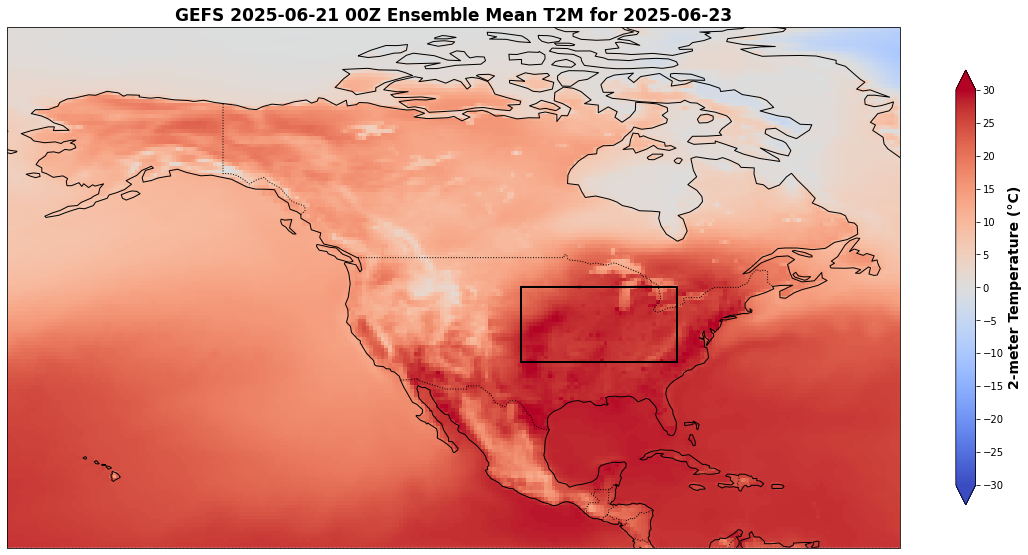

In [7]:
# Define box bounds for the Midwest.
midwest_box = {
    'lon_min': -101,
    'lon_max': -80,
    'lat_min': 35,
    'lat_max': 45
}
# Generate a figure.
fig = plt.figure(figsize=(20, 10))
# Add axes.
ax = plt.axes(projection=ccrs.PlateCarree())
# Plot the data with colorbar information.
plot = t2m_on_date['t2m'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-30, vmax=30, cbar_kwargs={
        'orientation': 'vertical',
        'shrink': 0.8,
        'extend': 'both',
        'ticks': list(range(-30, 35, 5))
    })
# Set extent for the map.
ax.set_extent([-170, -50, 10, 80], crs=ccrs.PlateCarree())
# Add coastlines and borders.
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add the Midwest region box rectangle
rect = Rectangle(
    (midwest_box['lon_min'], midwest_box['lat_min']),  # bottom-left corner
    midwest_box['lon_max'] - midwest_box['lon_min'],   # width
    midwest_box['lat_max'] - midwest_box['lat_min'],   # height
    linewidth=2,
    edgecolor='black',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(rect)

# Set the title.
ax.set_title(f'GEFS 2025-06-21 00Z Ensemble Mean T2M for {chosen_date}', fontsize = 17, weight = 'bold')
# Set colorbar details.
colorbar = plot.colorbar
colorbar.set_label('2-meter Temperature (°C)', fontsize=14, weight='bold')
# Show figure.
plt.show()

## How does the Midwest T2M evolve? Let's look at some ensemble time series.

In [8]:
# Now select just the Midwest but keep all ensemble members and valid times.

In [9]:
midwest_ds = ds.sel(latitude = slice(midwest_box['lat_max'], midwest_box['lat_min']), \
                    longitude = slice(360+midwest_box['lon_min'], 360+midwest_box['lon_max']))

In [10]:
midwest_ds

<xarray.Dataset>
Dimensions:     (latitude: 21, longitude: 43, number: 31, valid_time: 16)
Coordinates:
  * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
  * latitude    (latitude) float64 45.0 44.5 44.0 43.5 ... 36.5 36.0 35.5 35.0
  * longitude   (longitude) float64 259.0 259.5 260.0 ... 279.0 279.5 280.0
  * valid_time  (valid_time) datetime64[ns] 2025-06-21 2025-06-22 ... 2025-07-06
Data variables:
    t2m         (valid_time, number, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-06-21T23:28 GRIB to CDM+CF via cfgrib-0.9.1...

### Area average.

In [11]:
# Calculate the weights for latitude.
weights = np.cos(np.deg2rad(midwest_ds['latitude']))
# Now the area average.
area_ave = midwest_ds.weighted(weights).mean(dim=["latitude", "longitude"], skipna=True)

In [12]:
area_ave

<xarray.Dataset>
Dimensions:     (number: 31, valid_time: 16)
Coordinates:
  * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
  * valid_time  (valid_time) datetime64[ns] 2025-06-21 2025-06-22 ... 2025-07-06
Data variables:
    t2m         (valid_time, number) float64 299.6 299.4 299.7 ... 298.3 299.4

In [13]:
# Now get the T2M and time data.
ens_data = area_ave['t2m'].values - 273.15 # For Celsius
times = area_ave['valid_time'].values # Time stamps.

In [14]:
# Prepare data for boxplot: list of arrays, one per time
data = [ens_data[i, :] for i in range(ens_data.shape[0])]

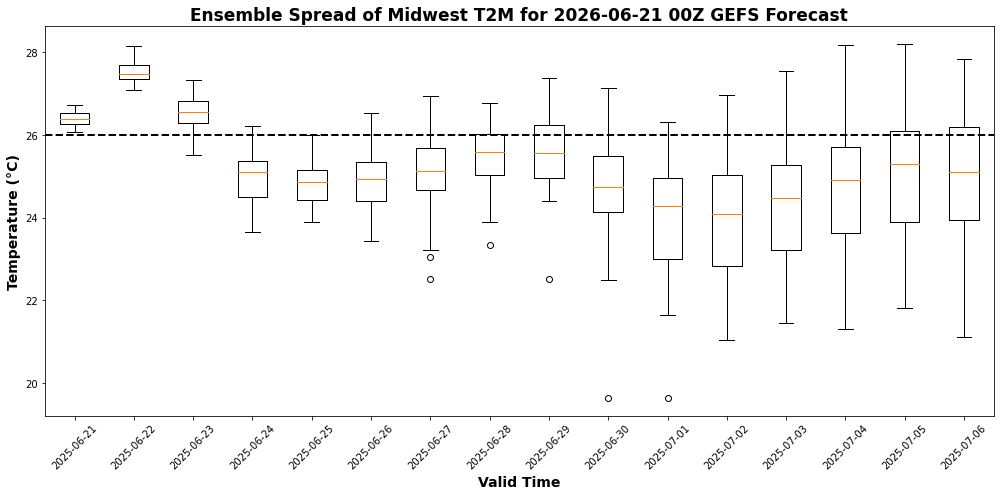

In [15]:
# Generate figure.
plt.figure(figsize=(14, 7))
# Do the boxplot.
plt.boxplot(data, positions=range(len(data)), showfliers=True)
# Label x-axis
if np.issubdtype(times.dtype, np.datetime64):
    # Convert times to strings for labels.
    labels = [str(t)[:10] for t in times]
else:
    labels = times
# Horizontal line for abitrary T2M for the next analysis.
plt.axhline(y = 26, ls = '--', lw = 2, color = 'black')
# Set x ticks.
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
# Set x label.
plt.xlabel('Valid Time', fontsize = 14, weight = 'bold')
# Set y label.
plt.ylabel('Temperature (°C)', fontsize = 14, weight = 'bold')
# Set title.
plt.title('Ensemble Spread of Midwest T2M for 2026-06-21 00Z GEFS Forecast', fontsize = 17, weight = 'bold')
# Tight layout.
plt.tight_layout()
# Show figure.
plt.show()

## Now let's see what the probability of exceeding 26C is for each forecast date.

In [16]:
# Assign 1 to each day of 26C+ or 0 if not.
binary_flag = (area_ave['t2m'] - 273.15 >= 26).astype(int).values

In [17]:
# Calculate probability.
prob = np.nanmean(binary_flag, axis = 1)*100 # For percent.

In [18]:
prob

array([100.        , 100.        ,  90.32258065,  12.90322581,
         3.22580645,   6.4516129 ,   9.67741935,  29.03225806,
        32.25806452,  16.12903226,   6.4516129 ,   6.4516129 ,
         9.67741935,  19.35483871,  29.03225806,  35.48387097])

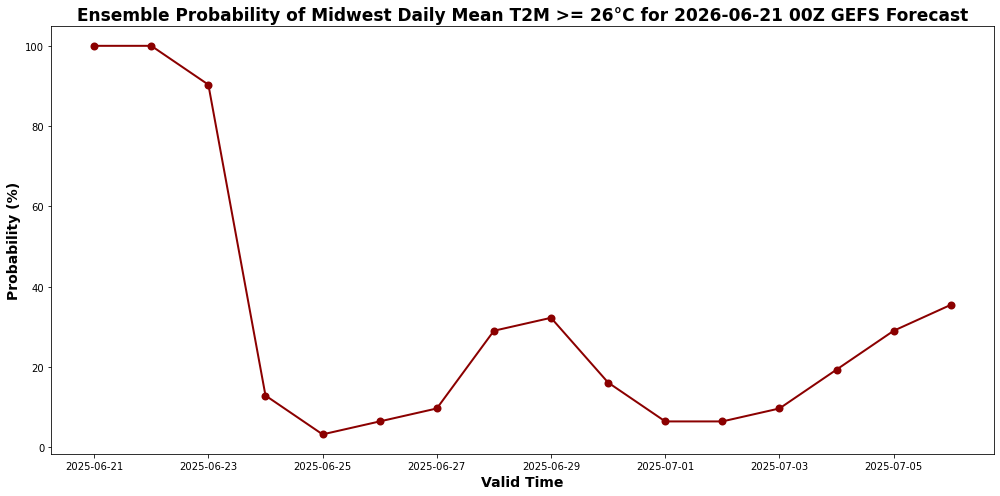

In [19]:
# Generate figure.
plt.figure(figsize=(14, 7))
# Plot the ensemble probability.
plt.plot(times, prob, color = 'darkred', lw = 2, ls = '-')
# Plot the scatter points too.
plt.scatter(times, prob, color = 'darkred', lw = 2, ls = '-')
# Set x label.
plt.xlabel('Valid Time', fontsize = 14, weight = 'bold')
# Set y label.
plt.ylabel('Probability (%)', fontsize = 14, weight = 'bold')
# Set title.
plt.title('Ensemble Probability of Midwest Daily Mean T2M >= 26°C for 2026-06-21 00Z GEFS Forecast', fontsize = 17, weight = 'bold')
# Tight layout.
plt.tight_layout()
# Show figure.
plt.show()